# TD3 trainer
this is the notebook I used for executing TD3 controller in MATLAB RL toolbox based environment. full python/pytorch, no weird dependencies

In [13]:
# train_td3_with_matlab_env.py


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR # Uncomment if you use schedulers
import numpy as np
import random
import time
import matlab.engine # Import the MATLAB Engine API
import os
import sys
import collections # For ReplayBuffer if using deque
import traceback # For printing detailed errors
import matplotlib.pyplot as plt

In [14]:
print("Starting Python script for TD3 training with MATLAB Environment...")

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(f"Using PyTorch device: {device}")

Starting Python script for TD3 training with MATLAB Environment...
True
Using PyTorch device: cuda


In [ ]:
# --- PyTorch Class Definitions ---
# (PASTE YOUR EXACT ReplayBuffer, Actor, Critic, TD3 CLASS DEFINITIONS HERE)
# --- CORRECTION: Simplify select_action ---
class ReplayBuffer:
    # ... ( __init__ and add methods remain the same) ...
    def __init__(self, max_size=5e5):
        self.buffer = collections.deque(maxlen=int(max_size))
        self.max_size = int(max_size)
    def add(self, transition):
        self.buffer.append(transition)
    def __len__(self): return len(self.buffer) # Add len if using deque

    def sample(self, batch_size):
        # Avoid sampling if buffer is smaller than batch size
        actual_batch_size = min(batch_size, len(self.buffer))
        if actual_batch_size <= 0:
            return None # Indicate no sample available

        indexes = np.random.randint(0, len(self.buffer), size=actual_batch_size)
        state, action, reward, next_state, done = [], [], [], [], []

        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            # --- Use np.asarray instead of np.array(..., copy=False) ---
            state.append(np.asarray(s))
            action.append(np.asarray(a))
            reward.append(np.asarray(r)) # Rewards are often scalars, asarray works fine
            next_state.append(np.asarray(s_))
            done.append(np.asarray(d)) # Dones are often scalars/booleans
            # ------------------------------------------------------------

        # Return as numpy arrays, conversion to tensor happens in TD3 update
        # Using stack is often better if dimensions are consistent
        try:
             return np.stack(state), np.stack(action), np.stack(reward), np.stack(next_state), np.stack(done)
        except ValueError as e_stack:
             # Fallback if stacking fails (e.g., inconsistent shapes if episode ends early?)
             print(f"Warning: np.stack failed in replay buffer sample ({e_stack}). Returning np.array.")
             return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

class Actor(nn.Module):
    # ... (Same as before) ...
     def __init__(self, state_dim, action_dim, max_action_val):
        super(Actor, self).__init__(); 
        self.l1 = nn.Linear(state_dim, 400); 
        self.l2 = nn.Linear(400, 300); 
        self.l3 = nn.Linear(300, action_dim)
     def forward(self, state): 
        a = F.relu(self.l1(state)); 
        a = F.relu(self.l2(a)); 
        a = torch.tanh(self.l3(a)); 
        return a

class Critic(nn.Module):
    # ... (Same as before) ...
     def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__(); 
        self.l1 = nn.Linear(state_dim + action_dim, 400);
        self.l2 = nn.Linear(400, 300); 
        self.l3 = nn.Linear(300, 1); 
        self.l4 = nn.Linear(state_dim + action_dim, 400); 
        self.l5 = nn.Linear(400, 300); 
        self.l6 = nn.Linear(300, 1)
     def forward(self, state, action): 
        sa = torch.cat([state, action], 1); 
        q1 = F.relu(self.l1(sa)); 
        q1 = F.relu(self.l2(q1)); 
        q1 = self.l3(q1); 
        q2 = F.relu(self.l4(sa)); 
        q2 = F.relu(self.l5(q2)); 
        q2 = self.l6(q2); 
        return q1, q2
     def Q1(self, state, action): 
        sa = torch.cat([state, action], 1); 
        q1 = F.relu(self.l1(sa)); 
        q1 = F.relu(self.l2(q1)); 
        q1 = self.l3(q1); 
        return q1


class TD3:
    def __init__(self, lr_actor, lr_critic, state_dim, action_dim, max_action_val):
        self.actor = Actor(state_dim, action_dim, max_action_val).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action_val).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.max_action_val = max_action_val # Max value for action scaling
        self.action_dim = action_dim
        self.total_it = 0

    def select_action(self, state): # REMOVED noise parameter here
        # state is numpy array
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        # Actor outputs [-1, 1]
        with torch.no_grad(): # No need for gradients during action selection
            action_unscaled = self.actor(state)
        # Scale action and return as numpy
        action_scaled = action_unscaled.cpu().data.numpy().flatten() * self.max_action_val
        return action_scaled

    # --- update, save, load methods remain the same as previous correct version ---
    def update(self, replay_buffer, batch_size, gamma, polyak, policy_noise_std, noise_clip, policy_delay):
        self.total_it += 1;
        if len(replay_buffer) < batch_size: return
        batch = replay_buffer.sample(batch_size);
        if batch is None: return
        state_np, action_scaled_np, reward_np, next_state_np, done_np = batch
        state = torch.FloatTensor(state_np).to(device); action_scaled = torch.FloatTensor(action_scaled_np).to(device); reward = torch.FloatTensor(reward_np).reshape((-1, 1)).to(device); next_state = torch.FloatTensor(next_state_np).to(device); done = torch.FloatTensor(done_np).reshape((-1, 1)).to(device)
        with torch.no_grad():
            # Use policy_noise_std here
            noise = (torch.randn_like(action_scaled) * policy_noise_std).clamp(-noise_clip, noise_clip);
            next_action_unscaled = self.actor_target(next_state); next_action_unscaled_noisy = (next_action_unscaled + noise).clamp(-1.0, 1.0);
            target_Q1, target_Q2 = self.critic_target(next_state, next_action_unscaled_noisy); target_Q = torch.min(target_Q1, target_Q2); target_Q = reward + (1.0 - done) * gamma * target_Q
        action_unscaled_buffer = action_scaled / self.max_action_val; current_Q1, current_Q2 = self.critic(state, action_unscaled_buffer); critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q);
        self.critic_optimizer.zero_grad(); critic_loss.backward(); self.critic_optimizer.step();
        if self.total_it % policy_delay == 0:
            actor_actions_unscaled = self.actor(state); actor_loss = -self.critic.Q1(state, actor_actions_unscaled).mean();
            self.actor_optimizer.zero_grad(); actor_loss.backward(); self.actor_optimizer.step();
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()): target_param.data.copy_(polyak * target_param.data + (1 - polyak) * param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()): target_param.data.copy_(polyak * target_param.data + (1 - polyak) * param.data)
    def save(self, filename): torch.save(self.actor.state_dict(), filename + "_actor.pth"); torch.save(self.critic.state_dict(), filename + "_critic.pth"); print(f"Saved Actor and Critic models to {filename}_actor/critic.pth")
    def load(self, filename): self.actor.load_state_dict(torch.load(filename + "_actor.pth", map_location=device)); self.actor_target.load_state_dict(self.actor.state_dict()); self.critic.load_state_dict(torch.load(filename + "_critic.pth", map_location=device)); self.critic_target.load_state_dict(self.critic.state_dict()); print(f"Loaded Actor and Critic models from {filename}_actor/critic.pth")

# --- End of Class Definitions ---

In [38]:
# Function to run one episode and collect detailed history
def run_evaluation_episode(policy, matlab_engine, matlab_env_handle, max_eval_steps=1000):
    """
    Runs one evaluation episode using the policy and returns state history.
    :param policy: (TD3) Trained policy agent.
    :param matlab_engine: (matlab.engine) The running MATLAB engine.
    :param matlab_env_handle: Handle to the MATLAB environment object.
    :param max_eval_steps: (int) Max steps for this evaluation episode.
    :return: tuple (t_history, q_history, omega_history) - NumPy arrays or None on error
    """
    print("\n--- Running Single Evaluation Episode for Plotting ---")
    t_history = []
    q_history = []
    omega_history = []

    try:
        matlab_obs, _ = matlab_engine.reset(matlab_env_handle, nargout=2)
        obs = np.array(matlab_obs).astype(np.float32).flatten()
        done = False
        steps = 0

        # Store initial state
        t_history.append(steps)
        q_history.append(obs[0:4]) # Assuming obs = [q1,q2,q3,q4, wx,wy,wz]
        omega_history.append(obs[4:7])

        while not done and steps < max_eval_steps:
            # --- Select action DETERMINISTICALLY ---
            # --- CORRECTED CALL: Remove noise_std argument ---
            action = policy.select_action(obs)
            # -----------------------------------------

            # Step environment
            action_ml = matlab.single(action.reshape(-1, 1))
            try: # Add try-except around step during evaluation too
                next_matlab_obs, reward_ml, done_ml, _ = matlab_engine.step(matlab_env_handle, action_ml, nargout=4)
            except Exception as e_step_eval:
                print(f"Error during evaluation step: {e_step_eval}")
                done = True # End episode on error
                break # Exit loop

            next_obs = np.array(next_matlab_obs).astype(np.float32).flatten()
            done = bool(done_ml)
            steps += 1

            # Store results
            t_history.append(steps)
            q_history.append(next_obs[0:4])
            omega_history.append(next_obs[4:7])

            # Update state for next iteration
            obs = next_obs

        print(f"Evaluation episode finished after {steps} steps.")
        # Convert lists to numpy arrays for easier plotting
        q_history_np = np.stack(q_history, axis=0).T # Transpose: rows = q1,q2,q3,q4; cols = time
        omega_history_np = np.stack(omega_history, axis=0).T # Transpose: rows = wx,wy,wz; cols = time
        t_history_np = np.array(t_history)

        return t_history_np, q_history_np, omega_history_np

    except Exception as e_eval:
        print(f"Error during evaluation run: {e_eval}")
        traceback.print_exc()
        return None, None, None

In [ ]:
# Function to create the plots
def plot_evaluation_results(t_history, q_history, omega_history, save_filename="evaluation_plots.png"):
    """
    Generates and saves plots for orientation and angular velocity.
    :param t_history: (np.array) Timestep history.
    :param q_history: (np.array) Quaternion history (4xN).
    :param omega_history: (np.array) Angular velocity history (3xN).
    :param save_filename: (str) Filename to save the plot.
    """
    if t_history is None or q_history is None or omega_history is None:
        print("Skipping plotting due to missing evaluation data.")
        return

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Evaluation Episode State Evolution', fontsize=16)

    # Plot Orientation (Error Quaternion)
    try:
        axs[0].plot(t_history, q_history[0, :], label='q1')
        axs[0].plot(t_history, q_history[1, :], label='q2')
        axs[0].plot(t_history, q_history[2, :], label='q3')
        axs[0].plot(t_history, q_history[3, :], label='q4 (scalar)')
        axs[0].set_ylabel("Quaternion Component")
        axs[0].set_title("Orientation (Error Quaternion) over Time")
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[0].grid(True, alpha=0.4)
        axs[0].set_ylim([-1.1, 1.1]) # Typical quaternion range
    except IndexError:
        print("Warning: Quaternion history has unexpected shape for plotting.")

    # Plot Angular Velocity
    try:
        axs[1].plot(t_history, omega_history[0, :], label='wx')
        axs[1].plot(t_history, omega_history[1, :], label='wy')
        axs[1].plot(t_history, omega_history[2, :], label='wz')
        axs[1].set_xlabel("Simulation Timestep")
        axs[1].set_ylabel("Ang. Velo. (rad/s)")
        axs[1].set_title("Angular Velocity over Time")
        axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[1].grid(True, alpha=0.4)
    except IndexError:
         print("Warning: Angular velocity history has unexpected shape for plotting.")

    plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # Adjust layout to prevent title overlap and make space for legend
    plt.savefig(save_filename)
    print(f"Evaluation plots saved to {save_filename}")
    plt.show()

In [33]:


# ================================================
# Main Training Script
# ================================================
if __name__ == "__main__":

    # --- Configuration ---
    matlab_env_creator_func = 'createAttitudeControlEnv'
    matlab_env_path = '.'

    # TD3 Hyperparameters
    lr_actor = 1e-4
    lr_critic = 1e-3
    gamma = 0.99
    polyak = 0.005
    policy_noise_std = 0.2 # Noise for target policy smoothing
    noise_clip = 0.5      # Clip for target policy smoothing noise
    policy_delay = 2
    expl_noise = 0.1       # <<< Exploration noise standard deviation (relative to max_action)

    # Training loop parameters
    start_timesteps = int(1000)
    max_timesteps = int(1e5)
    eval_freq = int(5000)
    save_model_freq = int(50000)
    batch_size = int(100)

    # Environment parameters (Python side)
    state_dim = 7
    action_dim = 3
    max_action = 0.5 # Max value for scaling action output

    # Python-side parameters dictionary
    params_py = {
        'maxEpisodeSteps': 500,
        'maxAngVelo': 0.5,
    }
    DEFAULT_MAX_STEPS = params_py['maxEpisodeSteps'] # Define fallback constant

    # Setup
    seed = 0
    save_model_dir = "./matlab_td3_models"
    os.makedirs(save_model_dir, exist_ok=True)
    file_name = f"TD3_MATLAB_Env_{seed}"

    # Set random seeds
    # ... (seed setting code) ...
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


Starting MATLAB engine...
MATLAB engine started successfully.
Added '.' to MATLAB path.
Instantiating MATLAB environment by calling 'createAttitudeControlEnv'...
MATLAB environment handle obtained.
Python TD3 policy and Replay Buffer initialized.
Starting training loop for 100000 timesteps...
Ep 1: T=500, Steps=500, Reward=-48.800
Ep 2: T=1000, Steps=500, Reward=0.200
Ep 3: T=1219, Steps=219, Reward=-4.800
Ep 4: T=1371, Steps=152, Reward=-27.300
Ep 5: T=1871, Steps=500, Reward=3.400
Ep 6: T=1935, Steps=64, Reward=-18.700
Ep 7: T=2267, Steps=332, Reward=-27.900
Ep 8: T=2325, Steps=58, Reward=-30.700
Ep 9: T=2382, Steps=57, Reward=-19.600
Ep 10: T=2439, Steps=57, Reward=-28.400
Ep 11: T=2496, Steps=57, Reward=-23.600
Ep 12: T=2553, Steps=57, Reward=-30.600
Ep 13: T=2610, Steps=57, Reward=-30.600
Ep 14: T=2668, Steps=58, Reward=-30.700
Ep 15: T=2725, Steps=57, Reward=-30.600
Ep 16: T=2783, Steps=58, Reward=-19.300
Ep 17: T=2840, Steps=57, Reward=-21.400
Ep 18: T=2898, Steps=58, Reward=-30

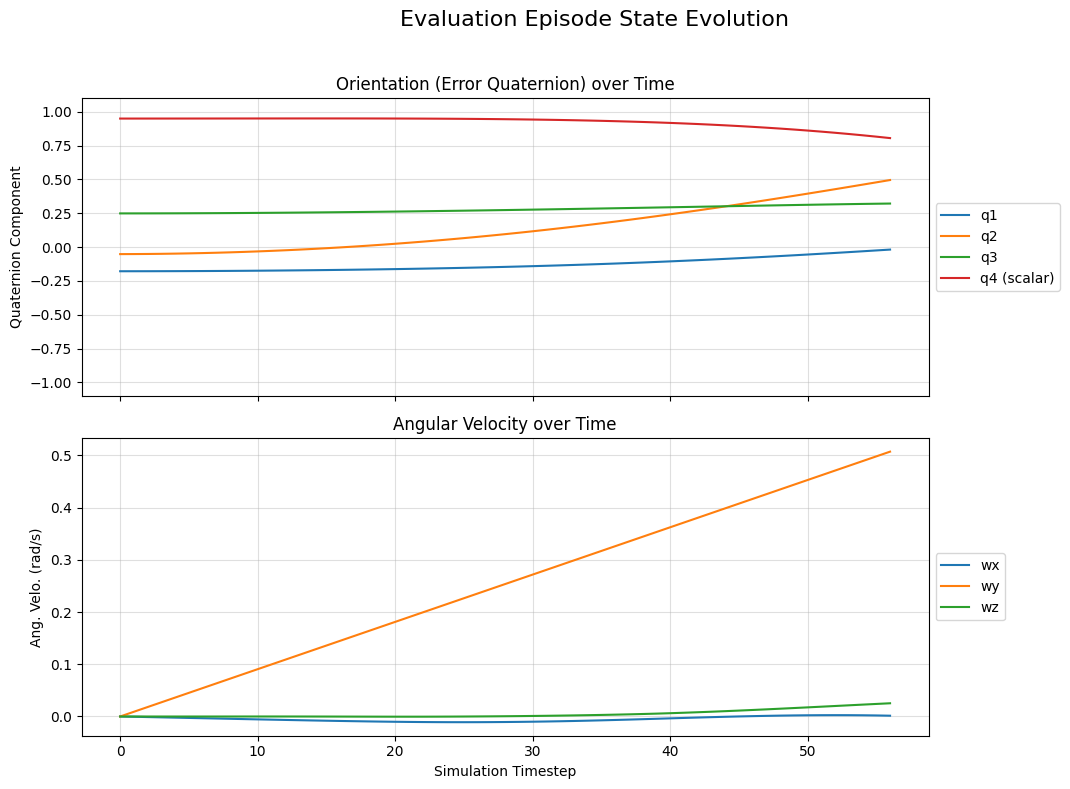

Training finished.


In [40]:

# --- Start MATLAB Engine ---
# ... (engine starting code) ...
print("Starting MATLAB engine...")
eng = None
try:
    eng = matlab.engine.start_matlab("-nodisplay")
    print("MATLAB engine started successfully.")
    eng.addpath(matlab_env_path, nargout=0)
    print(f"Added '{matlab_env_path}' to MATLAB path.")
except Exception as e:
    print(f"FATAL: Error starting MATLAB engine or adding path: {e}")
    sys.exit(1)


try:
    # --- Instantiate MATLAB Environment ---
    # ... (instantiate env code) ...
    print(f"Instantiating MATLAB environment by calling '{matlab_env_creator_func}'...")
    matlab_env = eng.eval(matlab_env_creator_func, nargout=1)
    print("MATLAB environment handle obtained.")


    # --- Initialize Policy and Replay Buffer ---
    policy = TD3(lr_actor, lr_critic, state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(max_size=int(1e6))
    print("Python TD3 policy and Replay Buffer initialized.")

    # --- Training Loop ---
    print(f"Starting training loop for {max_timesteps} timesteps...")
    total_timesteps = 0
    episode_num = 0
    evaluations = []

    while total_timesteps < max_timesteps:
        # --- Reset episode ---
        episode_reward = 0
        episode_timesteps = 0
        done = False

        matlab_obs, logged_signals = eng.reset(matlab_env, nargout=2)
        obs = np.array(matlab_obs).astype(np.float32).flatten()

        while True: # Inner loop for steps within an episode
            episode_timesteps += 1
            total_timesteps += 1

            # --- Select Action ---
            if total_timesteps < start_timesteps:
                # Take random action scaled to environment limits
                action = np.random.uniform(-max_action, max_action, action_dim)
            else:
                # Get deterministic action from policy (already scaled)
                action_deterministic = policy.select_action(obs)
                # Add exploration noise (scaled by max_action)
                noise = np.random.normal(0, max_action * expl_noise, size=action_dim) # <<< USE expl_noise HERE
                # Add noise and clip to the environment's action limits
                action = (action_deterministic + noise).clip(-max_action, max_action)

            # --- Step MATLAB Environment ---
            # ... (step env code as before) ...
            action_ml = matlab.double(action.reshape(-1, 1))
            try:
                next_matlab_obs, reward_ml, done_ml, logged_signals = eng.step(matlab_env, action_ml, nargout=4)
            except Exception as e_step:
                print(f"\nError during MATLAB eng.step at T={total_timesteps}: {e_step}")
                done = True # Force episode end
                break

            # --- Convert results ---
            # ... (convert results code as before) ...
            next_obs = np.array(next_matlab_obs).astype(np.float32).flatten()
            reward = float(reward_ml)
            done_bool = bool(done_ml)


            # --- Refine 'done' flag for Replay Buffer ---
            # ... (done flag refinement logic using DEFAULT_MAX_STEPS as before) ...
            max_steps_reached = False
            max_steps_default = DEFAULT_MAX_STEPS # Use defined constant
            if isinstance(logged_signals, dict):
                try:
                    current_matlab_steps = int(logged_signals.get('nSteps', -1))
                    max_episode_matlab_steps = int(logged_signals.get('MaxSteps', max_steps_default))
                    if current_matlab_steps >= 0:
                            max_steps_reached = bool(current_matlab_steps >= max_episode_matlab_steps)
                    else:
                            max_steps_reached = done_bool and episode_timesteps >= max_steps_default
                except (ValueError, KeyError, TypeError) as e_log:
                    print(f"Warning: Error processing logged_signals at T={total_timesteps}: {e_log}. Estimating truncation.")
                    max_steps_reached = done_bool and episode_timesteps >= max_steps_default
            else:
                print(f"Warning: logged_signals not dict ({type(logged_signals)}) at T={total_timesteps}. Estimating truncation.")
                max_steps_reached = done_bool and episode_timesteps >= max_steps_default

            real_done_for_buffer = 1.0 if (done_bool and not max_steps_reached) else 0.0


            # --- Store transition ---
            # ... (store transition code as before) ...
            replay_buffer.add((obs, action, reward, next_obs, real_done_for_buffer))


            # Update state
            obs = next_obs
            episode_reward += reward

            # --- Train Policy ---
            if total_timesteps >= start_timesteps:
                # Use the correctly defined policy_noise_std here
                policy.update(replay_buffer, batch_size, gamma, polyak, policy_noise_std, noise_clip, policy_delay)

            # --- Check episode end ---
            if done_bool:
                break # Exit inner while loop

        # --- End of Episode ---
        # ... (end of episode print and counter increment) ...
        print(f"Ep {episode_num + 1}: T={total_timesteps}, Steps={episode_timesteps}, Reward={episode_reward:.3f}")
        episode_num += 1


        # --- Periodic Evaluation ---
        # ... (evaluation logic placeholder) ...
        if total_timesteps >= start_timesteps and total_timesteps // eval_freq > (total_timesteps - episode_timesteps) // eval_freq :
                print(f"\n--- Evaluating Policy at Timestep {total_timesteps} (Placeholder) ---")
                print(f"--- Evaluation Complete ---")

        # --- Periodic Model Saving ---
        # ... (saving logic) ...
        if total_timesteps >= start_timesteps and total_timesteps // save_model_freq > (total_timesteps - episode_timesteps) // save_model_freq:
                policy.save(f"{save_model_dir}/{file_name}_ts{total_timesteps}")


        # Check outer loop condition
        if total_timesteps >= max_timesteps:
            print(f"Reached maximum total timesteps ({max_timesteps}). Stopping training.")
            break

# ... (except KeyboardInterrupt, Exception, finally block as before) ...
except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
except Exception as e:
    print(f"\n!!!!!!!! An error occurred during training !!!!!!!!")
    print(e)
    traceback.print_exc()

# --- Run Final Evaluation and Plot ---
if 'policy' in locals() and eng and 'matlab_env' in locals(): # Check if training ran and objects exist
    t_hist, q_hist, omega_hist = run_evaluation_episode(policy, eng, matlab_env, max_eval_steps=params_py['maxEpisodeSteps'] * 2) # Run for longer maybe
    plot_evaluation_results(t_hist, q_hist, omega_hist, save_filename=f"evaluation_{file_name}.png")
else:
    print("Skipping final evaluation plot as policy or environment was not fully initialized.")

    if eng:
        print("\nStopping MATLAB engine...")
        try:
            eng.quit()
            print("MATLAB engine stopped.")
        except Exception as e_quit:
            print(f"Error stopping MATLAB engine: {e_quit}")

print("Training finished.")

Starting Python script for evaluation and plotting...
Using PyTorch device: cpu
Python Actor model instantiated.
Successfully loaded trained actor weights from: ./matlab_td3_models\TD3_MATLAB_Env_0_ts50001_actor.pth
Starting MATLAB engine...
MATLAB engine started successfully.
Added '.' to MATLAB path.
Instantiating MATLAB environment by calling 'createAttitudeControlEnv'...
MATLAB environment handle obtained.

--- Running Single Evaluation Episode for 500 steps ---
Evaluation episode finished after 55 steps.
Evaluation plots saved to evaluation_plot_ts50001_500steps.png


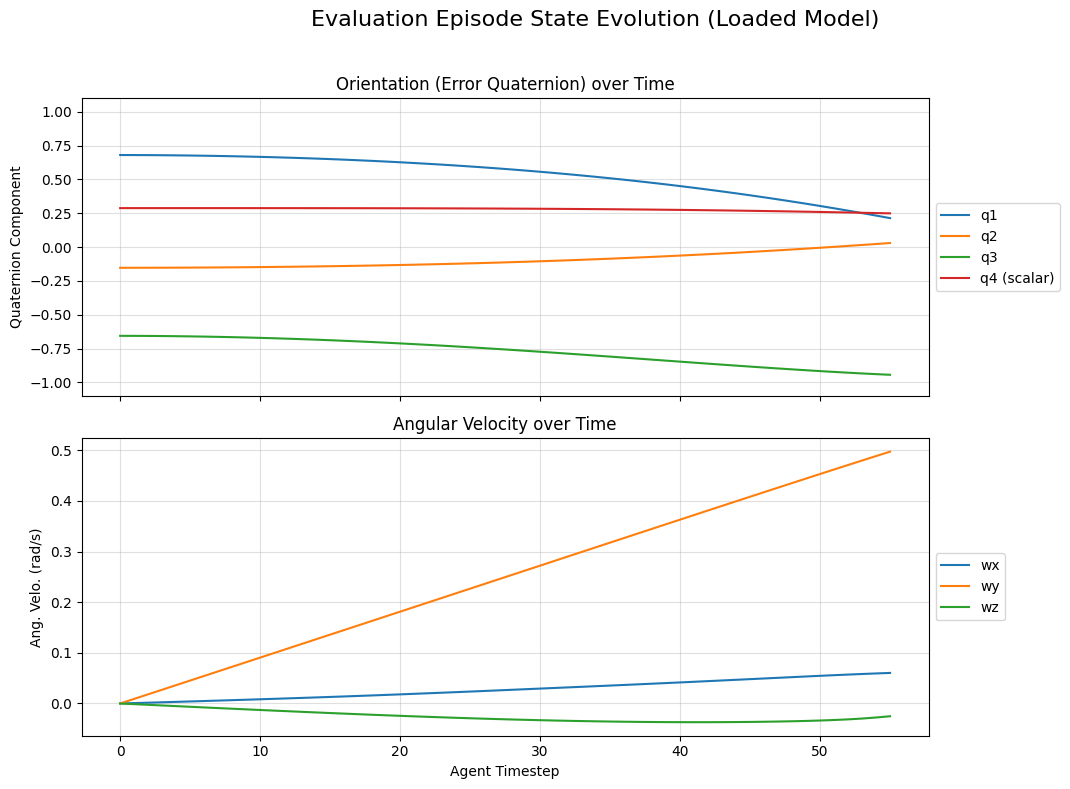


Stopping MATLAB engine...
MATLAB engine stopped.

Script finished.


In [47]:
import matplotlib.pyplot as plt # For plotting

print("Starting Python script for evaluation and plotting...")

# --- Device Setup ---
device = torch.device("cpu")
print(f"Using PyTorch device: {device}")

# --- PyTorch Actor Class Definition ---
# --- IMPORTANT: MUST MATCH the definition used during training ---
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action_val):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action_val = max_action_val # Store max_action for scaling

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) # Output scaled to [-1, 1]
        return a
# --- End of Actor Definition ---

# --- Configuration ---
matlab_env_creator_func = 'createAttitudeControlEnv' # Function name in .m file
matlab_env_path = '.' # Directory containing the .m file

# Model and Environment parameters (MUST MATCH TRAINING)
state_dim = 7
action_dim = 3
max_action = 0.5 # Max value for action scaling

# --- PATH TO YOUR SAVED ACTOR WEIGHTS ---
save_model_dir = "./matlab_td3_models" # Directory where models were saved
model_timestamp_tag = "ts50001" # The timestamp from the filename
seed_tag = "0" # The seed from the filename
actor_weights_filename = f"TD3_MATLAB_Env_{seed_tag}_{model_timestamp_tag}_actor.pth"
actor_weights_path = os.path.join(save_model_dir, actor_weights_filename)

# --- Evaluation parameters ---
# --- SET THE NUMBER OF STEPS FOR THE PLOT ---
num_eval_steps = 500
# ------------------------------------------

# --- Plotting Configuration ---
plot_save_filename = f"evaluation_plot_{model_timestamp_tag}_500steps.png" # Indicate steps in name

# --- Instantiate the Actor model ---
actor_model = Actor(state_dim, action_dim, max_action).to(device)
print("Python Actor model instantiated.")

# --- Load Trained Actor Weights ---
if not os.path.exists(actor_weights_path):
    print(f"FATAL: Actor weights file not found at: {actor_weights_path}")
    sys.exit(1)
try:
    actor_model.load_state_dict(torch.load(actor_weights_path, map_location=device))
    actor_model.eval() # Set to evaluation mode
    print(f"Successfully loaded trained actor weights from: {actor_weights_path}")
except Exception as e:
    print(f"FATAL: Error loading weights from {actor_weights_path}: {e}")
    sys.exit(1)

# --- Helper Function to Get Deterministic Action ---
def get_deterministic_action(state_np):
    state = torch.FloatTensor(state_np.reshape(1, -1)).to(device)
    with torch.no_grad():
        action_unscaled = actor_model(state) # Output is [-1, 1]
    # Scale action from [-1, 1] to [-max_action, max_action]
    action_scaled = action_unscaled.cpu().data.numpy().flatten() * max_action
    # Clip just in case (optional, but safe)
    action_scaled = np.clip(action_scaled, -max_action, max_action)
    return action_scaled

# --- Helper Function to Run Evaluation ---
def run_evaluation_episode(policy_actor, matlab_engine, matlab_env_handle, max_eval_steps):
    print(f"\n--- Running Single Evaluation Episode for {max_eval_steps} steps ---")
    t_history = []
    q_history = []
    omega_history = []
    try:
        matlab_obs, _ = matlab_engine.reset(matlab_env_handle, nargout=2)
        obs = np.array(matlab_obs).astype(np.float32).flatten()
        done = False
        steps = 0
        t_history.append(steps)
        q_history.append(obs[0:4])
        omega_history.append(obs[4:7])

        while not done and steps < max_eval_steps: # Loop exactly max_eval_steps times unless done early
            action = get_deterministic_action(obs) # Use the helper
            action_ml = matlab.single(action.reshape(-1, 1), size=(action_dim, 1))
            try:
                next_matlab_obs, reward_ml, done_ml, _ = matlab_engine.step(matlab_env_handle, action_ml, nargout=4)
            except Exception as e_step:
                print(f"Error during MATLAB eng.step at step {steps+1}: {e_step}")
                break
            next_obs = np.array(next_matlab_obs).astype(np.float32).flatten()
            done = bool(done_ml)
            steps += 1
            t_history.append(steps)
            q_history.append(next_obs[0:4])
            omega_history.append(next_obs[4:7])
            obs = next_obs

        print(f"Evaluation episode finished after {steps} steps.")
        q_history_np = np.stack(q_history, axis=0).T
        omega_history_np = np.stack(omega_history, axis=0).T
        t_history_np = np.array(t_history)
        return t_history_np, q_history_np, omega_history_np
    except Exception as e_eval:
        print(f"Error during evaluation run: {e_eval}")
        traceback.print_exc()
        return None, None, None

# --- Helper Function to Plot Results ---
def plot_evaluation_results(t_history, q_history, omega_history, save_filename):
     if t_history is None or q_history is None or omega_history is None: print("Skipping plotting: missing data."); return
     fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True); fig.suptitle('Evaluation Episode State Evolution (Loaded Model)', fontsize=16)
     try: # Orientation Plot
        axs[0].plot(t_history, q_history[0, :], label='q1'); axs[0].plot(t_history, q_history[1, :], label='q2'); axs[0].plot(t_history, q_history[2, :], label='q3'); axs[0].plot(t_history, q_history[3, :], label='q4 (scalar)')
        axs[0].set_ylabel("Quaternion Component"); axs[0].set_title("Orientation (Error Quaternion) over Time"); axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5)); axs[0].grid(True, alpha=0.4); axs[0].set_ylim([-1.1, 1.1])
     except IndexError: print("Warning: Quat history shape error")
     try: # Angular Velocity Plot
        axs[1].plot(t_history, omega_history[0, :], label='wx'); axs[1].plot(t_history, omega_history[1, :], label='wy'); axs[1].plot(t_history, omega_history[2, :], label='wz')
        axs[1].set_xlabel("Agent Timestep"); axs[1].set_ylabel("Ang. Velo. (rad/s)"); axs[1].set_title("Angular Velocity over Time"); axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5)); axs[1].grid(True, alpha=0.4)
     except IndexError: print("Warning: Omega history shape error")
     plt.tight_layout(rect=[0, 0, 0.9, 0.96]); plt.savefig(save_filename); print(f"Evaluation plots saved to {save_filename}"); plt.show()

# ================================================
# Main Execution Block
# ================================================
if __name__ == "__main__":

    # --- Start MATLAB Engine ---
    print("Starting MATLAB engine...")
    eng = None
    try:
        eng = matlab.engine.start_matlab("-nodisplay")
        print("MATLAB engine started successfully.")
        eng.addpath(matlab_env_path, nargout=0)
        print(f"Added '{matlab_env_path}' to MATLAB path.")
    except Exception as e:
        print(f"FATAL: Error starting MATLAB engine or adding path: {e}")
        sys.exit(1)

    # --- Run Evaluation and Plot ---
    try:
        # Instantiate MATLAB Environment
        print(f"Instantiating MATLAB environment by calling '{matlab_env_creator_func}'...")
        matlab_env = eng.eval(matlab_env_creator_func, nargout=1)
        print("MATLAB environment handle obtained.")

        # Run the evaluation episode using the loaded actor model
        t_hist, q_hist, omega_hist = run_evaluation_episode(
            actor_model, # Pass the loaded PyTorch model object
            eng,
            matlab_env,
            max_eval_steps=num_eval_steps # Use the variable defined above (500)
            )

        # Plot the collected data
        plot_evaluation_results(
            t_hist,
            q_hist,
            omega_hist,
            save_filename=plot_save_filename
            )

    except Exception as e:
        print(f"\n!!!!!!!! An error occurred during evaluation or plotting !!!!!!!!")
        print(e)
        traceback.print_exc()

    finally:
        # --- Stop MATLAB Engine ---
        if eng:
            print("\nStopping MATLAB engine...")
            try: eng.quit()
            except: pass # Ignore errors during quit
            print("MATLAB engine stopped.")

    print("\nScript finished.")